In [2375]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import statistics
import copy

training data

In [2376]:
# import data
df = pd.read_csv("data/5_missing_5000sample.csv")
data = df.to_numpy()
(l, w) = data.shape

In [2377]:
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            x_train[i, d*2] = missing_ind
            x_train[i, d*2+1] = missing_ind
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score

In [2378]:
# x_train = data.reshape((-1, 28))
# x_train.shape

In [2379]:
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x_train, test_size=0.20)

Autoencoder model

In [2380]:
(l, w)

(5000, 2)

In [2381]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 2
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, 20),
            torch.nn.Sigmoid()
            # torch.nn.Linear(10, 5)
        )
         
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(5, 10),
            # torch.nn.Sigmoid(),
            torch.nn.Linear(20, n_domains * 2),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [2382]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-4,
                             weight_decay = 1e-8)

In [2383]:
def missing(arr):
    return arr[0] == arr[1]

In [2384]:
epochs = 25
outputs = []
losses = []
val_losses = []
epoch_loss = []
val_epoch_loss = []

for epoch in range(epochs):
    for session in x_train:

      optimizer.zero_grad()

      # Output of Autoencoder
      session_rs = session.reshape(-1, w * 2)
      session_t = torch.from_numpy(session_rs)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
      reconstructed = model(session_t)

      # handle missing value
      missing_exists = False
      missing_domains = []
      for domain in range(w):
        if missing(session[domain*2:domain*2+2]):
          missing_exists = True
          missing_domains.append(domain)
          
      if missing_exists:
        session_dc = copy.deepcopy(session)
        for d in missing_domains:
          target = reconstructed.detach().numpy()[0][d*2:d*2+2]
          session_dc[d*2:d*2+2] = target
        session_dc = session_dc.reshape(-1, w * 2)
        session_t = torch.from_numpy(session_dc)
        session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, session_t)
      
      loss.backward()
      optimizer.step()
      # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
       
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())

    losses.append(statistics.mean(epoch_loss))
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {statistics.mean(epoch_loss):.4f}')
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

    with torch.no_grad():
      for val in x_val:
        val_rs = val.reshape(-1, w * 2)
        val_t = torch.from_numpy(val_rs)
        val_t = val_t.clone().detach().type(torch.float32)
        answer = model(val_t)
        val_loss = loss_function(answer, val_t)
        val_epoch_loss.append(val_loss.item())
    val_losses.append(statistics.mean(val_epoch_loss))

Epoch [1/25], Loss: 0.0773
Epoch [2/25], Loss: 0.0710
Epoch [3/25], Loss: 0.0621
Epoch [4/25], Loss: 0.0497
Epoch [5/25], Loss: 0.0351
Epoch [6/25], Loss: 0.0210
Epoch [7/25], Loss: 0.0100
Epoch [8/25], Loss: 0.0038
Epoch [9/25], Loss: 0.0016
Epoch [10/25], Loss: 0.0012
Epoch [11/25], Loss: 0.0012
Epoch [12/25], Loss: 0.0012
Epoch [13/25], Loss: 0.0012
Epoch [14/25], Loss: 0.0012
Epoch [15/25], Loss: 0.0012
Epoch [16/25], Loss: 0.0012
Epoch [17/25], Loss: 0.0012
Epoch [18/25], Loss: 0.0012
Epoch [19/25], Loss: 0.0012
Epoch [20/25], Loss: 0.0012
Epoch [21/25], Loss: 0.0012
Epoch [22/25], Loss: 0.0012
Epoch [23/25], Loss: 0.0011
Epoch [24/25], Loss: 0.0011
Epoch [25/25], Loss: 0.0011


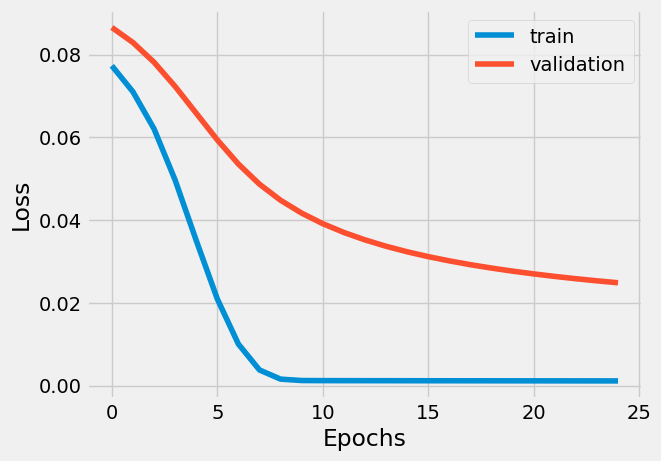

In [2385]:
 # Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting
with torch.no_grad():
   plt.plot(losses)
   plt.plot(val_losses)
   plt.legend(["train", "validation"])

In [2386]:
np.mean(x_train, axis=0)

array([0.49530838, 0.50844162, 0.5019538 , 0.4962962 ])

Testing all missing average

In [2394]:
missing_data = pd.read_csv("data/all_1_500.csv")
missing_data = missing_data.to_numpy()
(l, w) = missing_data.shape

In [2395]:
missing_set = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = missing_data[i, d]
        # update output array
        missing_set[i, d*2] = p
        missing_set[i, d*2+1] = p
missing_set

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [2396]:
total = np.array([0.0, 0.0, 0.0, 0.0])
with torch.no_grad():
    for row in missing_set:
        temp = row.reshape(-1, w * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        output = model(temp).detach().numpy()[0]
        total = output + total

total = total/l
total

array([0.50915027, 0.48718908, 0.53434455, 0.46891469])

No missing test

In [2397]:
test_data = pd.read_csv("data/test_dataset_no_missing_2.csv")
test_data = test_data.to_numpy()
(l, w) = test_data.shape

In [2398]:
x_test = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = test_data[i, d]
        x_test[i, d*2] = p # score
        x_test[i, d*2+1] = 1-p # 1-score

In [2399]:
x_test

array([[0.78208023, 0.21791977, 0.3816844 , 0.6183156 ],
       [0.39358905, 0.60641095, 0.31200055, 0.68799945],
       [0.0572248 , 0.9427752 , 0.78475412, 0.21524588],
       ...,
       [0.25542948, 0.74457052, 0.88261002, 0.11738998],
       [0.6164064 , 0.3835936 , 0.15777525, 0.84222475],
       [0.89770934, 0.10229066, 0.6429232 , 0.3570768 ]])

In [2400]:
total_loss = 0
with torch.no_grad():
    for row in x_test:
        temp = row.reshape(-1, w * 2)
        temp = torch.from_numpy(temp)
        temp = temp.clone().detach().type(torch.float32)
        
        output = model(temp)
        loss = loss_function(output, temp).detach().numpy()
        total_loss += loss

total_loss/l

0.0011803214301269237